In [1]:
%matplotlib inline

In [2]:
import itertools
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.fft import rfft, rfftfreq
from scipy.signal import argrelmin
from tqdm.notebook import tqdm

In [3]:
from types import SimpleNamespace

import scipy.constants

###################################################################
# Units
# Length : nm
# Energy : meV
# Current : nA
# Temperature : K

constants = SimpleNamespace(
    hbar=scipy.constants.hbar,
    m_e=scipy.constants.m_e,
    eV=scipy.constants.eV,
    e=scipy.constants.e,
    meV=scipy.constants.eV * 1e-3,
    k_B=scipy.constants.k / (scipy.constants.eV * 1e-3),
    mu_B=scipy.constants.physical_constants["Bohr magneton"][0]
    / (scipy.constants.eV * 1e-3),
    current_unit=scipy.constants.k * scipy.constants.e / scipy.constants.hbar * 1e9,
)

In [4]:
plt.style.use("../../sans_style.mplstyle")
plt.close("all")


pd_cmap = mpl.colors.ListedColormap(
    ["darkorange", "gold", "lightgreen", "lightseagreen"]
)
line_colors = [
    "xkcd:bright sky blue",
    "xkcd:cobalt blue",
    "xkcd:bright purple",
    "xkcd:bordeaux",
]


def add_tl_label(ax, text, color=[1, 1, 1, 0.90]):
    ax.text(
        0.03,
        0.96,
        text,
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
        bbox=dict(boxstyle="square", facecolor=color, linewidth=0, pad=0.20),
    )

In [5]:
simname = "Fig3a"

a_label = r"$h_\mathrm{all} / \Delta$"
b_label = r"$\mu_C / \Delta$"

Delta_0 = 0.250
a_scale = Delta_0
b_scale = Delta_0

In [6]:
ds = xr.open_dataset(f"./output/{simname}/{simname}.nc")

ws = ds["ws"]
a_N, b_N, theta_N, k = ws.shape

a_ax = ds.coords["a"].to_numpy()
b_ax = ds.coords["b"].to_numpy()

a, b = np.meshgrid(a_ax, b_ax, indexing="ij")

theta_ax = ds.coords["theta"].to_numpy()
theta_N = theta_ax.shape[0]
dtheta = theta_ax[1] - theta_ax[0]

In [7]:
def logcosh(x):
    ax = np.abs(x)
    return ax if ax > 2 else np.log(2 * np.cosh(x))


logcosh = np.frompyfunc(logcosh, 1, 1)

In [8]:
# Set the temperature
T = 20e-3  # mK

f = -(constants.k_B * T) * logcosh(ws / (2 * constants.k_B * T))
F = np.sum(f, axis=-1)

F.name = "F"

In [9]:
arm = argrelmin(F.to_numpy(), axis=-1, order=1, mode="wrap")

mins_list = [[[] for _ in range(b_N)] for __ in range(a_N)]
vmins_list = [[[] for _ in range(b_N)] for __ in range(a_N)]

for n in range(len(arm[0])):
    i = arm[0][n]
    j = arm[1][n]
    n = arm[2][n]

    mins_list[i][j].append(theta_ax[n])
    vmins_list[i][j].append(F[i, j, n])

In [10]:
pd = np.zeros((a_N, b_N)) * np.nan
pdm = np.zeros((a_N, b_N)) * np.nan
pdf = np.zeros((a_N, b_N)) * np.nan

for i, j in tqdm(np.ndindex(a_N, b_N), total=a_N * b_N):

    if len(mins_list[i][j]) == 1:
        if abs(mins_list[i][j][0]) < abs(mins_list[i][j][0] - np.pi):
            pd[i][j] = 0
        else:
            pd[i][j] = 3.14

    elif len(mins_list[i][j]) == 2:
        vmmin = np.argmin(vmins_list[i][j])
        mmin = mins_list[i][j][vmmin]

        if abs(mmin) < abs(mmin - np.pi):
            pd[i][j] = 3.14 / 3
        else:
            pd[i][j] = 2 * 3.14 / 3

    else:
        pd[i][j] = np.mean(mins_list[i][j])
    pdm[i][j] = np.mean(mins_list[i][j])
    pdf[i][j] = mins_list[i][j][0]

  0%|          | 0/17161 [00:00<?, ?it/s]

In [11]:
_I = (np.roll(F.to_numpy(), -1, axis=-1) - F.to_numpy()) / dtheta
_I *= 2 * constants.e / constants.hbar * constants.meV * 1e9

_I_c = np.zeros((a_N, b_N))
for i, j in np.ndindex(a_N, b_N):
    _I_c[i, j] = _I[i, j, np.argmax(np.abs(_I[i, j, : theta_N // 2]), axis=-1)]

I = xr.zeros_like(F)
I[:, :, :] = _I

I_c = xr.DataArray(_I_c, dims=("a", "b"), coords={"a": a_ax, "b": b_ax})

I_0 = 2 * constants.e * Delta_0 / constants.hbar * constants.meV * 1e9

In [12]:
N = F.shape[-1]

ks = rfftfreq(N, 1 / N)
F_k = 2.0 / N * rfft(F)
cF_k = +F_k.real
sF_k = -F_k.imag

In [13]:
a_coord = 7
b_coord = 78

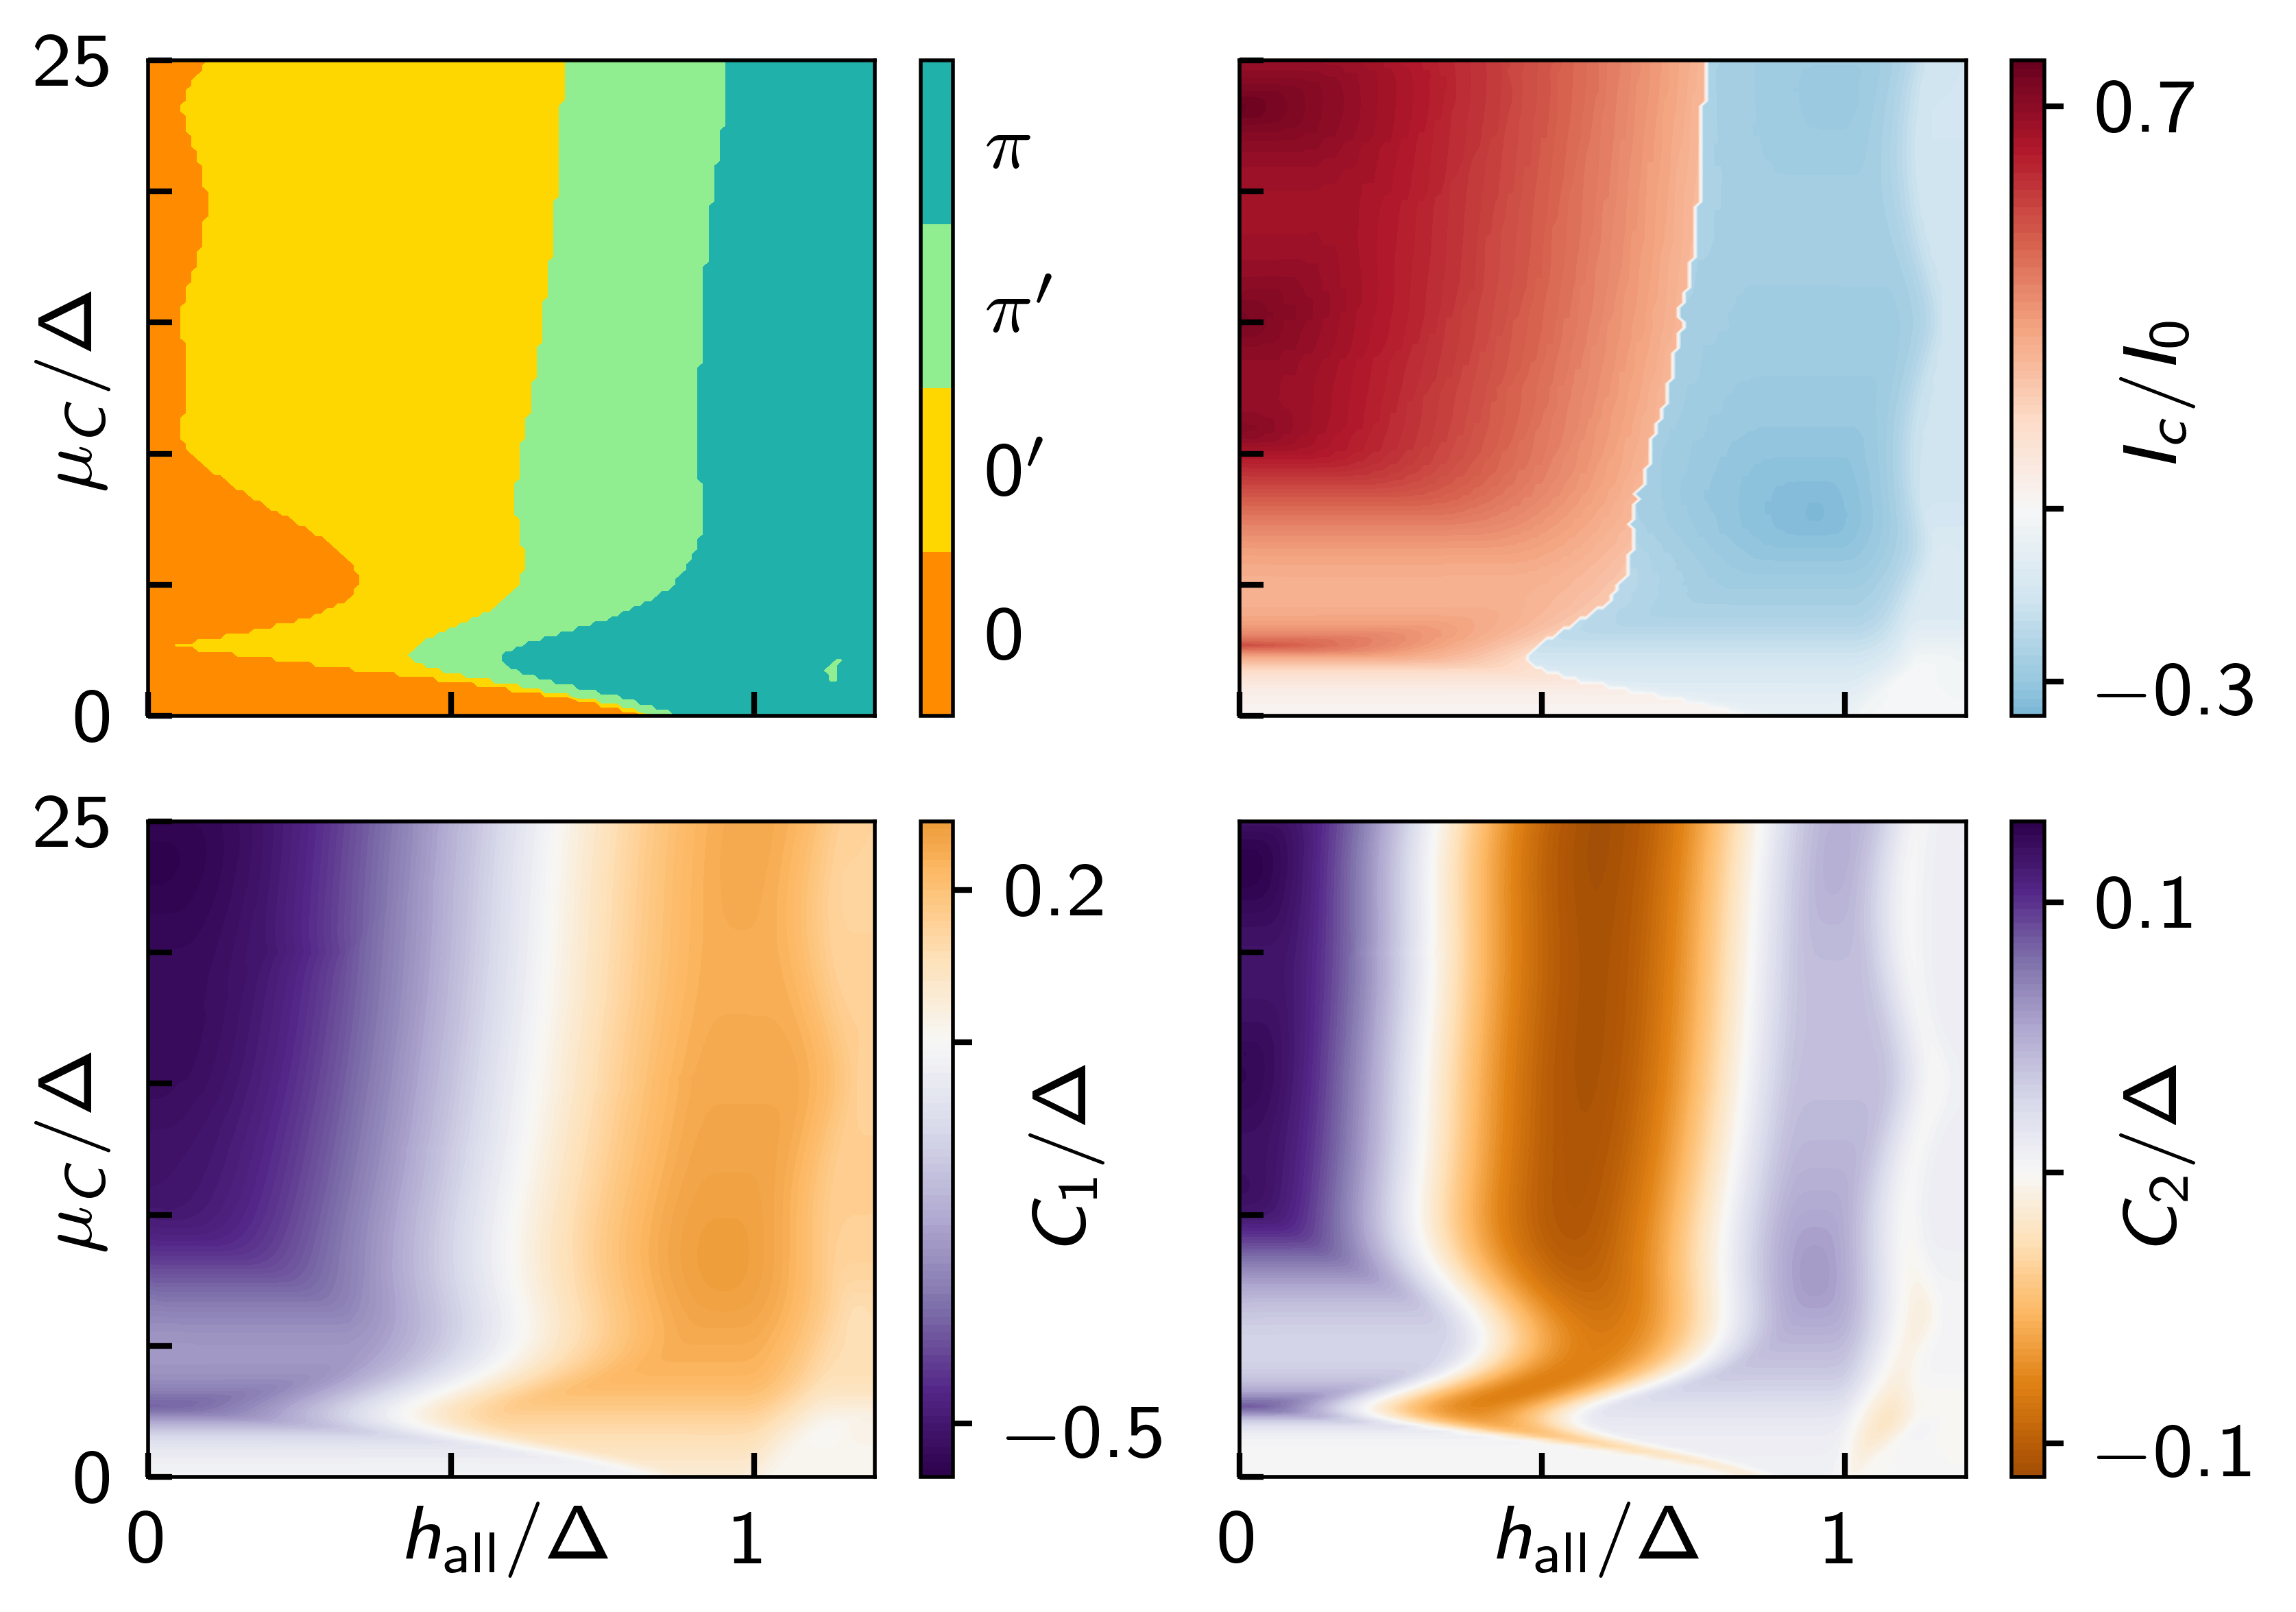

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    dpi=1000, figsize=(3.375, 3.375 * 0.7), ncols=2, nrows=2
)

ax1.set_rasterization_zorder(0)
ax2.set_rasterization_zorder(0)
ax3.set_rasterization_zorder(0)
ax4.set_rasterization_zorder(0)

levels = np.linspace(0, 3.2, 5)

im = ax1.contourf(a / a_scale, b / b_scale, pd, levels=levels, cmap=pd_cmap, zorder=-30)

cbar1 = fig.colorbar(im, ax=ax1)
cbar1.set_ticks([1 / 8 * 3.2, 3 / 8 * 3.2, 5 / 8 * 3.2, 7 / 8 * 3.2])
cbar1.set_ticklabels([r"$0$", r"$0'$", r"$\pi'$", r"$\pi$"])
cbar1.ax.tick_params(length=0)

im = ax2.contourf(
    a / a_scale,
    b / b_scale,
    I_c / I_0,
    levels=100,
    norm=mpl.colors.CenteredNorm(),
    cmap="RdBu_r",
    zorder=-30,
)
cbar2 = fig.colorbar(im, ax=ax2)
cbar2.set_ticks([-0.3, 0, 0.7], labels=[r"$-0.3$", "", r"$0.7$"])
cbar2.ax.tick_params(length=2, direction="out")
cbar2.set_label(r"$I_c / I_0$", labelpad=-15)


im3 = ax3.contourf(
    a / a_scale,
    b / b_scale,
    cF_k[:, :, 1] / Delta_0,
    levels=100,
    norm=mpl.colors.CenteredNorm(0),
    cmap="PuOr_r",
    zorder=-30,
)
cbar3 = fig.colorbar(im3, ax=ax3, format="%3.2f")
cbar3.set_ticks([-0.5, 0, 0.2], labels=[r"$-0.5$", "", r"$0.2$"])
cbar3.ax.tick_params(length=2, direction="out")
cbar3.set_label(r"$C_1 / \Delta$", labelpad=-15)

im4 = ax4.contourf(
    a / a_scale,
    b / b_scale,
    cF_k[:, :, 2] / Delta_0,
    levels=100,
    norm=mpl.colors.CenteredNorm(0),
    cmap="PuOr",
    zorder=-30,
)
cbar4 = fig.colorbar(im4, ax=ax4, format="%3.2f")
cbar4.set_ticks([-0.1, 0, 0.1], labels=[r"$-0.1$", "", r"$0.1$"])
cbar4.ax.tick_params(length=2, direction="out")
cbar4.set_label(r"$C_2 / \Delta$", labelpad=-15)

ax1.set_xticks([0, 0.5, 1])
ax1.set_xticklabels([])
# ax1.set_xlabel(a_label)
ax1.set_yticks([0, 5, 10, 15, 20, 25])
ax1.set_yticklabels([r"$0$", r"", r"", r"", r"", r"$25$"])
ax1.set_ylabel(b_label, labelpad=-8)

ax2.set_xticks([0, 0.5, 1])
ax2.set_xticklabels([])
# ax2.set_xlabel(a_label)
ax2.set_yticks([0, 5, 10, 15, 20, 25])
ax2.set_yticklabels([])
# ax2.set_ylabel(b_label)

ax3.set_xticks([0, 0.5, 1])
ax3.set_xticklabels([r"$0$", r"", r"$1$"])
ax3.set_xlabel(a_label, labelpad=-8)
ax3.set_yticks([0, 5, 10, 15, 20, 25])
ax3.set_yticklabels([r"$0$", r"", r"", r"", r"", r"$25$"])
ax3.set_ylabel(b_label, labelpad=-8)

ax4.set_xticks([0, 0.5, 1])
ax4.set_xticklabels([r"$0$", r"", r"$1$"])
ax4.set_xlabel(a_label, labelpad=-8)
ax1.set_yticks([0, 5, 10, 15, 20, 25])
ax4.set_yticklabels([])
# ax4.set_ylabel(b_label)

# ax3.hlines(b_ax[b_coord] /b_scale, a_ax.min()/a_scale, a_ax.max()/a_scale, colors='k', linestyles='--')
# ax4.hlines(b_ax[b_coord] /b_scale, a_ax.min()/a_scale, a_ax.max()/a_scale, colors='k', linestyles='--')
# ax3.vlines(a_ax[a_coord] /a_scale, b_ax.min()/b_scale, b_ax.max()/b_scale, colors='k', linestyles='--')
# ax4.vlines(a_ax[a_coord] /a_scale, b_ax.min()/b_scale, b_ax.max()/b_scale, colors='k', linestyles='--')

##########################


# ax5.plot(
#     b[0, :] / b_scale,
#     np.abs(cF_k[a_coord, :, 1] / np.max(np.abs(cF_k[:, :, 1]))),
#     "-",
#     label="$C_1$",
# )
# ax5.plot(
#     b[0, :] / b_scale,
#     np.abs(cF_k[a_coord, :, 2] / np.max(np.abs(cF_k[:, :, 2]))),
#     "-",
#     label="$C_2$",
# )
# ax5.plot(
#     b[0, :] / b_scale,
#     np.abs(cF_k[a_coord, :, 3] / np.max(np.abs(cF_k[:, :, 3]))),
#     "-",
#     label="$C_3$",
# )

# ax5.set_xticks([0, 5, 10, 15, 20, 25])
# ax5.set_xticklabels([r"$0$", r"", r"", r"", r"", r"$25$"])
# ax5.set_xlabel(b_label, labelpad=-8)

# ax5.set_ylabel(r"$\frac{|C_k|}{\max(|C_k|)}$", labelpad=-5)
# ax5.set_yticks([0, 0.5, 1])
# ax5.set_yticklabels([r"$0$", "", r"$1$"])
# #ax5.set_ylim(-0.1, 1.25)
# ax5.legend()#ncol=3)

# ax6.plot(
#     a[:, b_coord] / a_scale,
#     (cF_k[:, b_coord, 1] / np.max(np.abs(cF_k[:, :, 1]))),
#     "-",
#     label="$C_1$",
# )
# ax6.plot(
#     a[:, b_coord] / a_scale,
#     (cF_k[:, b_coord, 2] / np.max(np.abs(cF_k[:, :, 2]))),
#     "-",
#     label="$C_2$",
# )
# ax6.plot(
#     a[:, b_coord] / a_scale,
#     (cF_k[:, b_coord, 3] / np.max(np.abs(cF_k[:, :, 3]))),
#     "-",
#     label="$C_3$",
# )
# ax6.set_xticks([0, 0.5, 1])
# ax6.set_xticklabels([r"$0$", r"", r"$1$"])
# ax6.set_xlabel(a_label, labelpad=-8)

# ax6.set_ylabel(r"$\frac{C_k}{\max(|C_k|)}$", labelpad=-8)
# ax6.set_yticks([-1, 0, 1])
# ax6.set_yticklabels([r"$-1$", "", r"$1$"])

fig.tight_layout(pad=0.5)

In [15]:
diffabs = abs(cF_k[..., 2]) - abs(cF_k[..., 1])

In [16]:
I = I.to_numpy().astype(float)

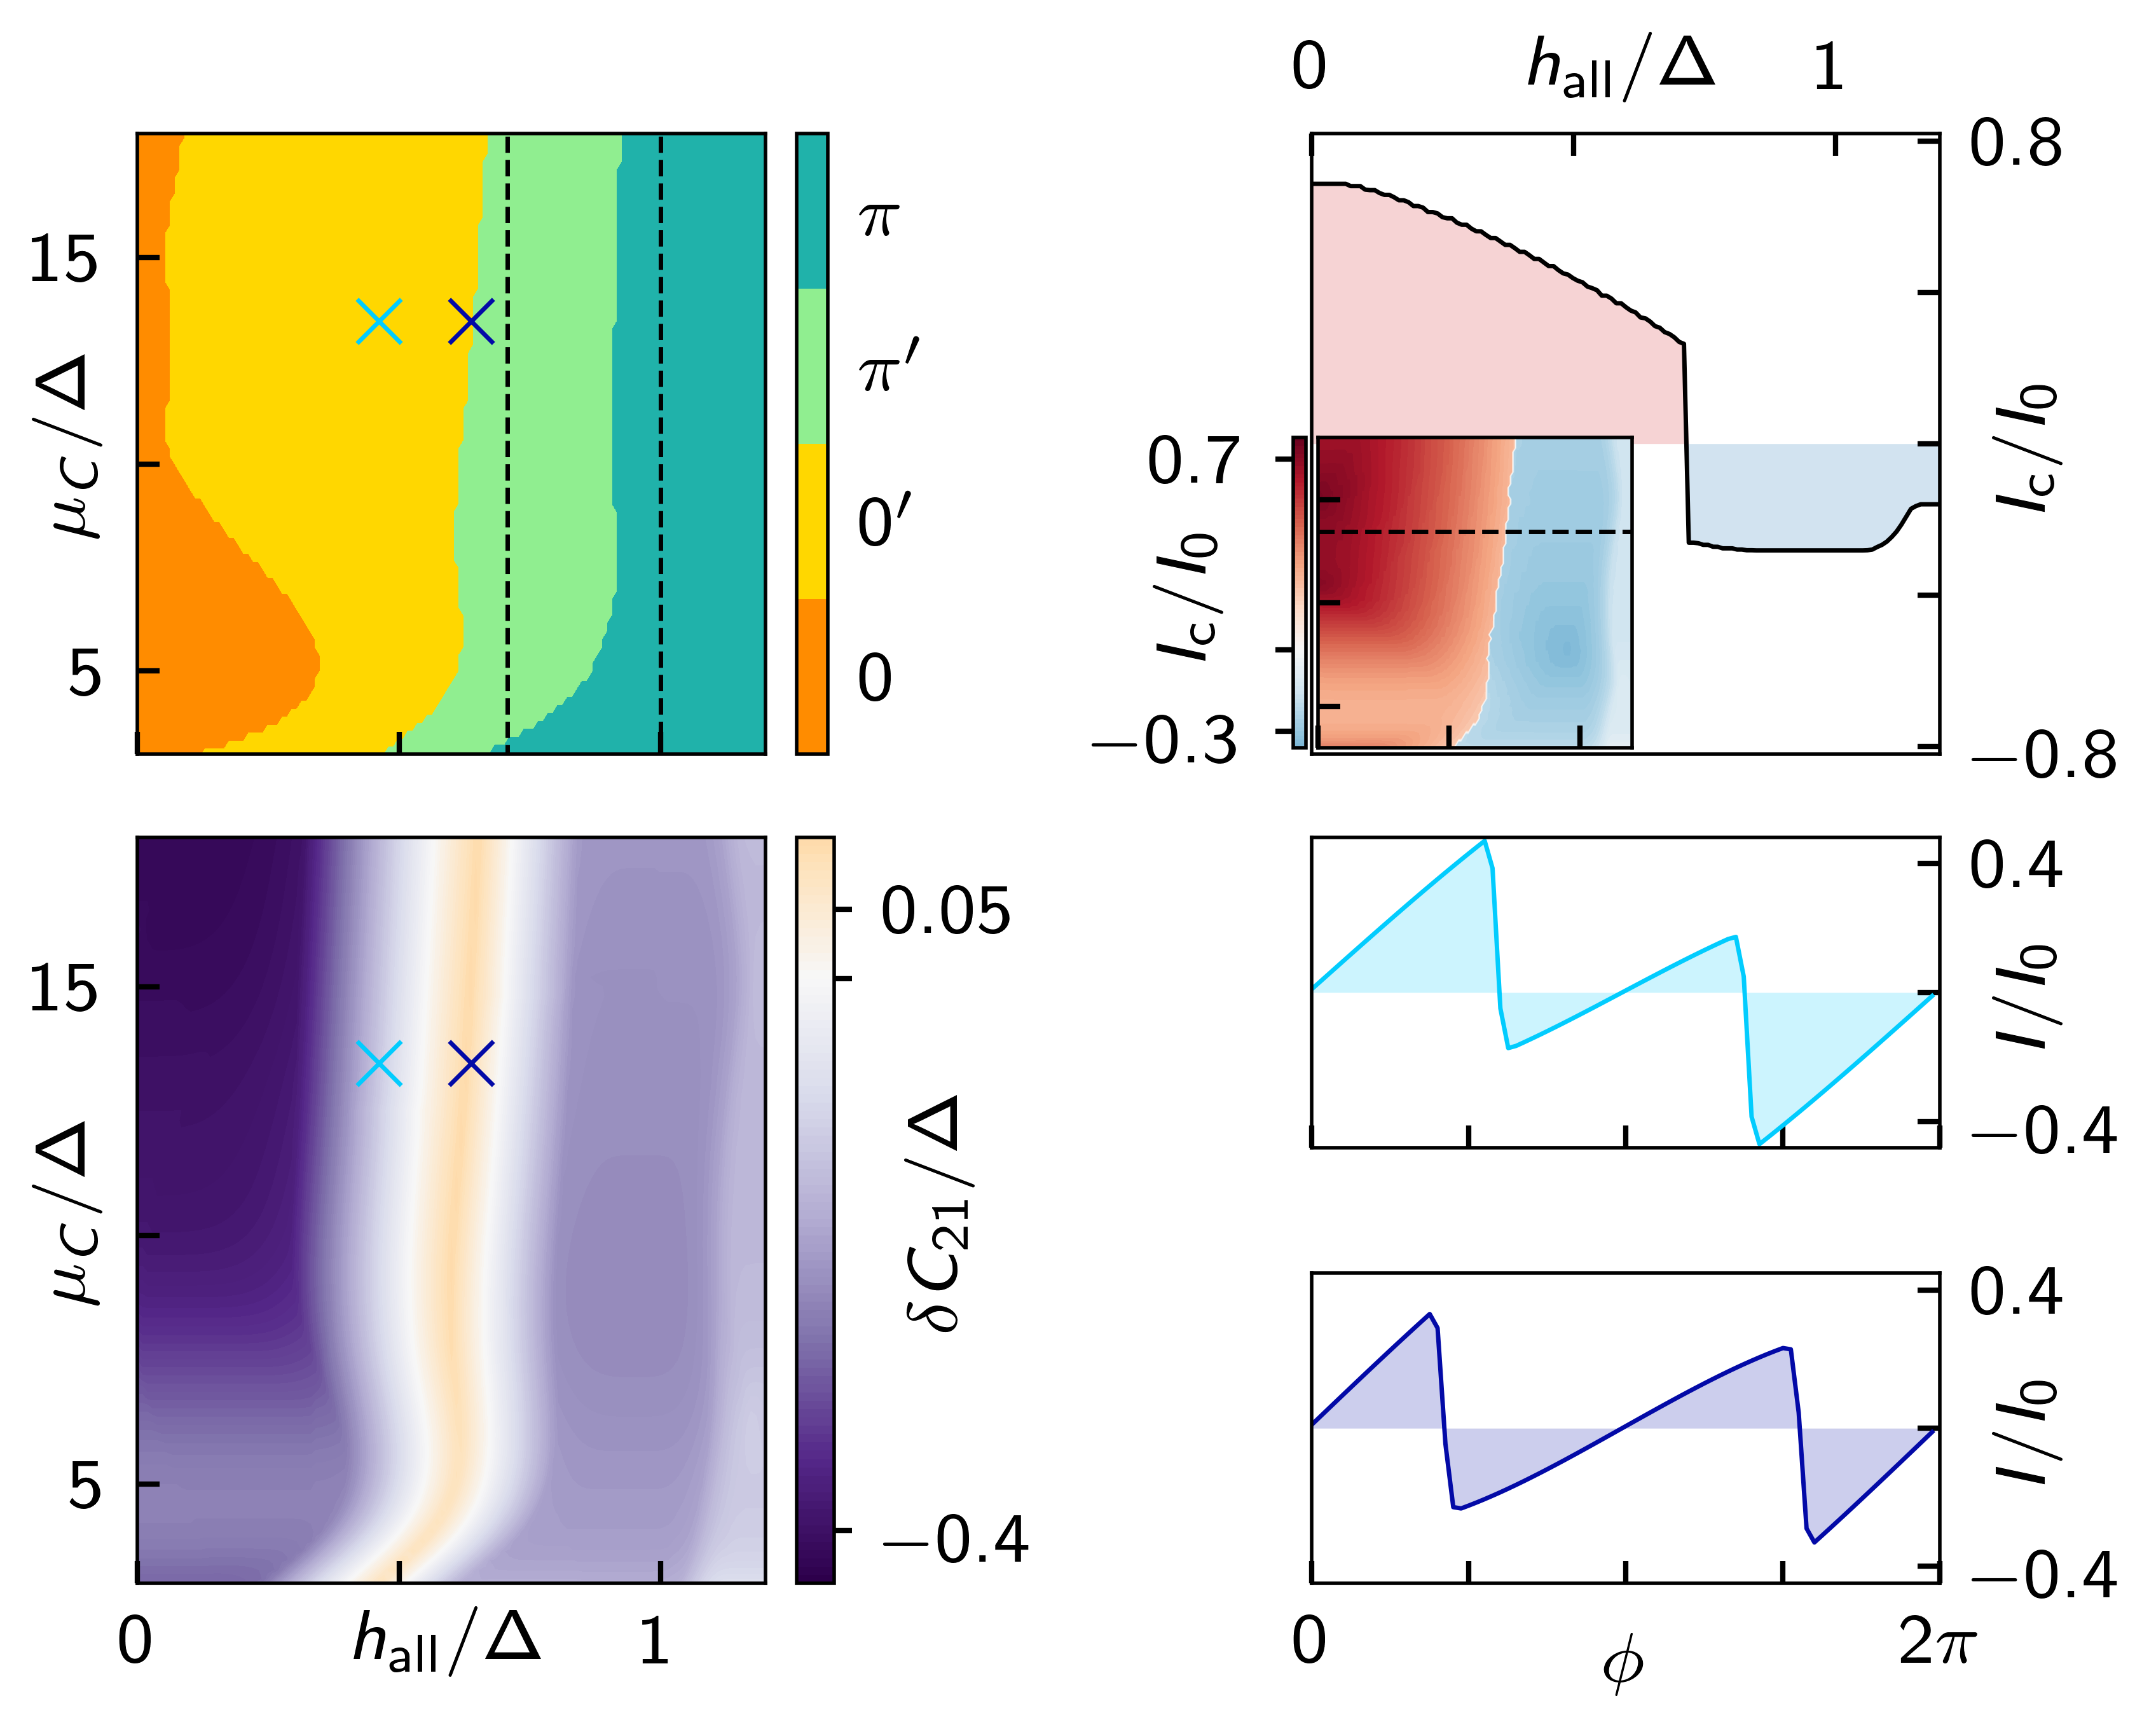

In [17]:
b_cut_idx = 70

coords_1 = [50, 70]
coords_2 = [69, 70]


fig = plt.figure(dpi=1000, figsize=(3.375, 3.375 * 0.8), layout="constrained")
spec = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1])

ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[1:3, 0])
ax4 = fig.add_subplot(spec[1, 1])
ax5 = fig.add_subplot(spec[2, 1])

ax1.set_rasterization_zorder(0)
ax3.set_rasterization_zorder(0)

##############################################################

levels = np.linspace(0, 3.2, 5)

im1 = ax1.contourf(
    a / a_scale, b / b_scale, pd, levels=levels, cmap=pd_cmap, zorder=-30
)

ax1.scatter(
    a_ax[coords_1[0]] / a_scale,
    b_ax[coords_1[1]] / b_scale,
    color=line_colors[0],
    marker="x",
)
ax1.scatter(
    a_ax[coords_2[0]] / a_scale,
    b_ax[coords_2[1]] / b_scale,
    color=line_colors[1],
    marker="x",
)

ax1.set_xticks([0, 0.5, 1])
ax1.set_xticklabels([])
# ax1.set_xlabel(a_label)

ax1.set_ylim(3, 18)
ax1.set_yticks([5, 10, 15])
ax1.set_yticklabels([r"$5$", r"", r"$15$"])
ax1.set_ylabel(b_label, labelpad=-8)

ax1.vlines(
    [1 / np.sqrt(2), 1],
    b_ax.min() / b_scale,
    b_ax.max() / b_scale,
    color="k",
    linestyles="--",
    linewidths=0.5,
)

#############################################################
ax2.plot(a_ax / a_scale, I_c[:, b_cut_idx] / I_0, "-k")
ax2.fill_between(
    x=a_ax / a_scale,
    y1=I_c[:, b_cut_idx] / I_0 * (I_c[:, b_cut_idx] < 0),
    y2=0,
    color="C0",
    alpha=0.2,
    linewidth=0,
)
ax2.fill_between(
    x=a_ax / a_scale,
    y1=I_c[:, b_cut_idx] / I_0 * (I_c[:, b_cut_idx] > 0),
    y2=0,
    color="C3",
    alpha=0.2,
    linewidth=0,
)

ax2.set_xlim(0, 1.2)
ax2.set_xticks([0, 0.5, 1], labels=[r"$0$", r"", r"$1$"])
ax2.xaxis.tick_top()
ax2.set_xlabel(a_label, labelpad=-5)
ax2.xaxis.set_label_position("top")

ax2.set_ylim(-0.82, 0.82)
ax2.set_yticks([-0.8, -0.4, 0, 0.4, 0.8], labels=[r"$-0.8$", r"", r"", r"", r"$0.8$"])
ax2.yaxis.tick_right()
ax2.set_ylabel(r"$I_\mathrm{c}/I_0$", labelpad=-15)
ax2.yaxis.set_label_position("right")

################################################################
im3 = ax3.contourf(
    a / a_scale,
    b / b_scale,
    (diffabs) / Delta_0,
    levels=100,
    norm=mpl.colors.CenteredNorm(0),
    cmap="PuOr_r",
    zorder=-30,
)

ax3.set_xticks([0, 0.5, 1], labels=[r"$0$", r"", r"$1$"])
ax3.set_xlabel(a_label, labelpad=-8)

ax3.set_ylim(3, 18)
ax3.set_yticks([5, 10, 15], labels=[r"$5$", r"", r"$15$"])
ax3.set_ylabel(b_label, labelpad=-8)

ax3.scatter(
    a_ax[coords_1[0]] / a_scale,
    b_ax[coords_1[1]] / b_scale,
    color=line_colors[0],
    marker="x",
)
ax3.scatter(
    a_ax[coords_2[0]] / a_scale,
    b_ax[coords_2[1]] / b_scale,
    color=line_colors[1],
    marker="x",
)

###########################################
ax4.fill_between(
    x=theta_ax,
    y1=I[coords_1[0], coords_1[1]] / I_0,
    y2=0,
    color=line_colors[0],
    alpha=0.2,
    linewidth=0,
)

ax4.plot(
    theta_ax,
    I[coords_1[0], coords_1[1]] / I_0,
    "-",
    color=line_colors[0],
)

ax4.set_xlim(0, 2 * np.pi)
ax4.set_xticks(np.array([0, 0.5, 1, 1.5, 2]) * np.pi, labels=[])

ax4.set_ylim(-0.48, 0.48)
ax4.set_yticks(np.array([-0.4, 0, 0.4]), labels=[r"$-0.4$", r"", r"$0.4$"])
ax4.set_ylabel(r"$I/I_0$", labelpad=-15)
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()

ax5.fill_between(
    x=theta_ax,
    y1=I[coords_2[0], coords_2[1]] / I_0,
    y2=0,
    color=line_colors[1],
    alpha=0.2,
    linewidth=0,
)

ax5.plot(
    theta_ax,
    I[coords_2[0], coords_2[1]] / I_0,
    "-",
    color=line_colors[1],
)

ax5.set_xticks(
    np.array([0, 0.5, 1, 1.5, 2]) * np.pi, labels=[r"$0$", r"", r"", r"", r"$2\pi$"]
)
ax5.set_xlabel(r"$\phi$", labelpad=-5)
ax5.set_xlim(0, 2 * np.pi)

ax5.yaxis.set_label_position("right")
ax5.yaxis.tick_right()
ax5.set_ylim(-0.45, 0.45)
ax5.set_ylabel(r"$I/I_0$", labelpad=-15)
ax5.set_yticks(np.array([-0.4, 0, 0.4]), labels=[r"$-0.4$", r"", r"$0.4$"])

# spec.tight_layout(fig)

#########################################
cbar1 = fig.colorbar(im1, ax=ax1)
cbar1.set_ticks([1 / 8 * 3.2, 3 / 8 * 3.2, 5 / 8 * 3.2, 7 / 8 * 3.2])
cbar1.set_ticklabels([r"$0$", r"$0'$", r"$\pi'$", r"$\pi$"])
cbar1.ax.tick_params(length=0)

#########################################
cbar3 = fig.colorbar(im3, ax=ax3, format="%3.2f")
cbar3.set_ticks([-0.4, 0, 0.05], labels=[r"$-0.4$", "", r"$0.05$"])
cbar3.ax.tick_params(length=2, direction="out")
cbar3.set_label(r"$\delta C_{21} / \Delta$", labelpad=-15)

#########################################
axins = ax2.inset_axes([0.01, 0.01, 0.5, 0.5])
axins.set_rasterization_zorder(0)

im = axins.contourf(
    a / a_scale,
    b / b_scale,
    I_c / I_0,
    levels=100,
    norm=mpl.colors.CenteredNorm(),
    cmap="RdBu_r",
    zorder=-30,
)

axins.hlines([b_ax[b_cut_idx] / b_scale], 0, 1.2, colors="k", linestyles="--")

axins.set_xticks([0, 0.5, 1])
axins.set_xticklabels([])

axins.set_ylim(3, 18)
axins.set_yticks([5, 10, 15], labels=[])

###################################
# cb_axins = ax2.inset_axes([0.01, 0.52, 0.5, 0.02])
# cbar2 = fig.colorbar(im, cax=cb_axins, orientation="horizontal")
# cbar2.set_ticks([-0.3, 0, 0.7], labels=[r"$-0.3$", "", r"$0.7$"])
# cbar2.ax.xaxis.set_label_position("top")
# cbar2.ax.xaxis.tick_top()
# cbar2.ax.tick_params(length=2, direction="out")
# cbar2.set_label(r"$I_\mathrm{c} / I_0$", labelpad=-5)

cb_axins = ax2.inset_axes([-0.03, 0.01, 0.02, 0.5])
cbar2 = fig.colorbar(im, cax=cb_axins)

cbar2.set_ticks([-0.3, 0, 0.7], labels=[r"$-0.3$", "", r"$0.7$"])
cbar2.ax.yaxis.set_label_position("left")
cbar2.ax.yaxis.tick_left()
cbar2.ax.tick_params(length=2, direction="out")
cbar2.set_label(r"$I_\mathrm{c} / I_0$", labelpad=-15)

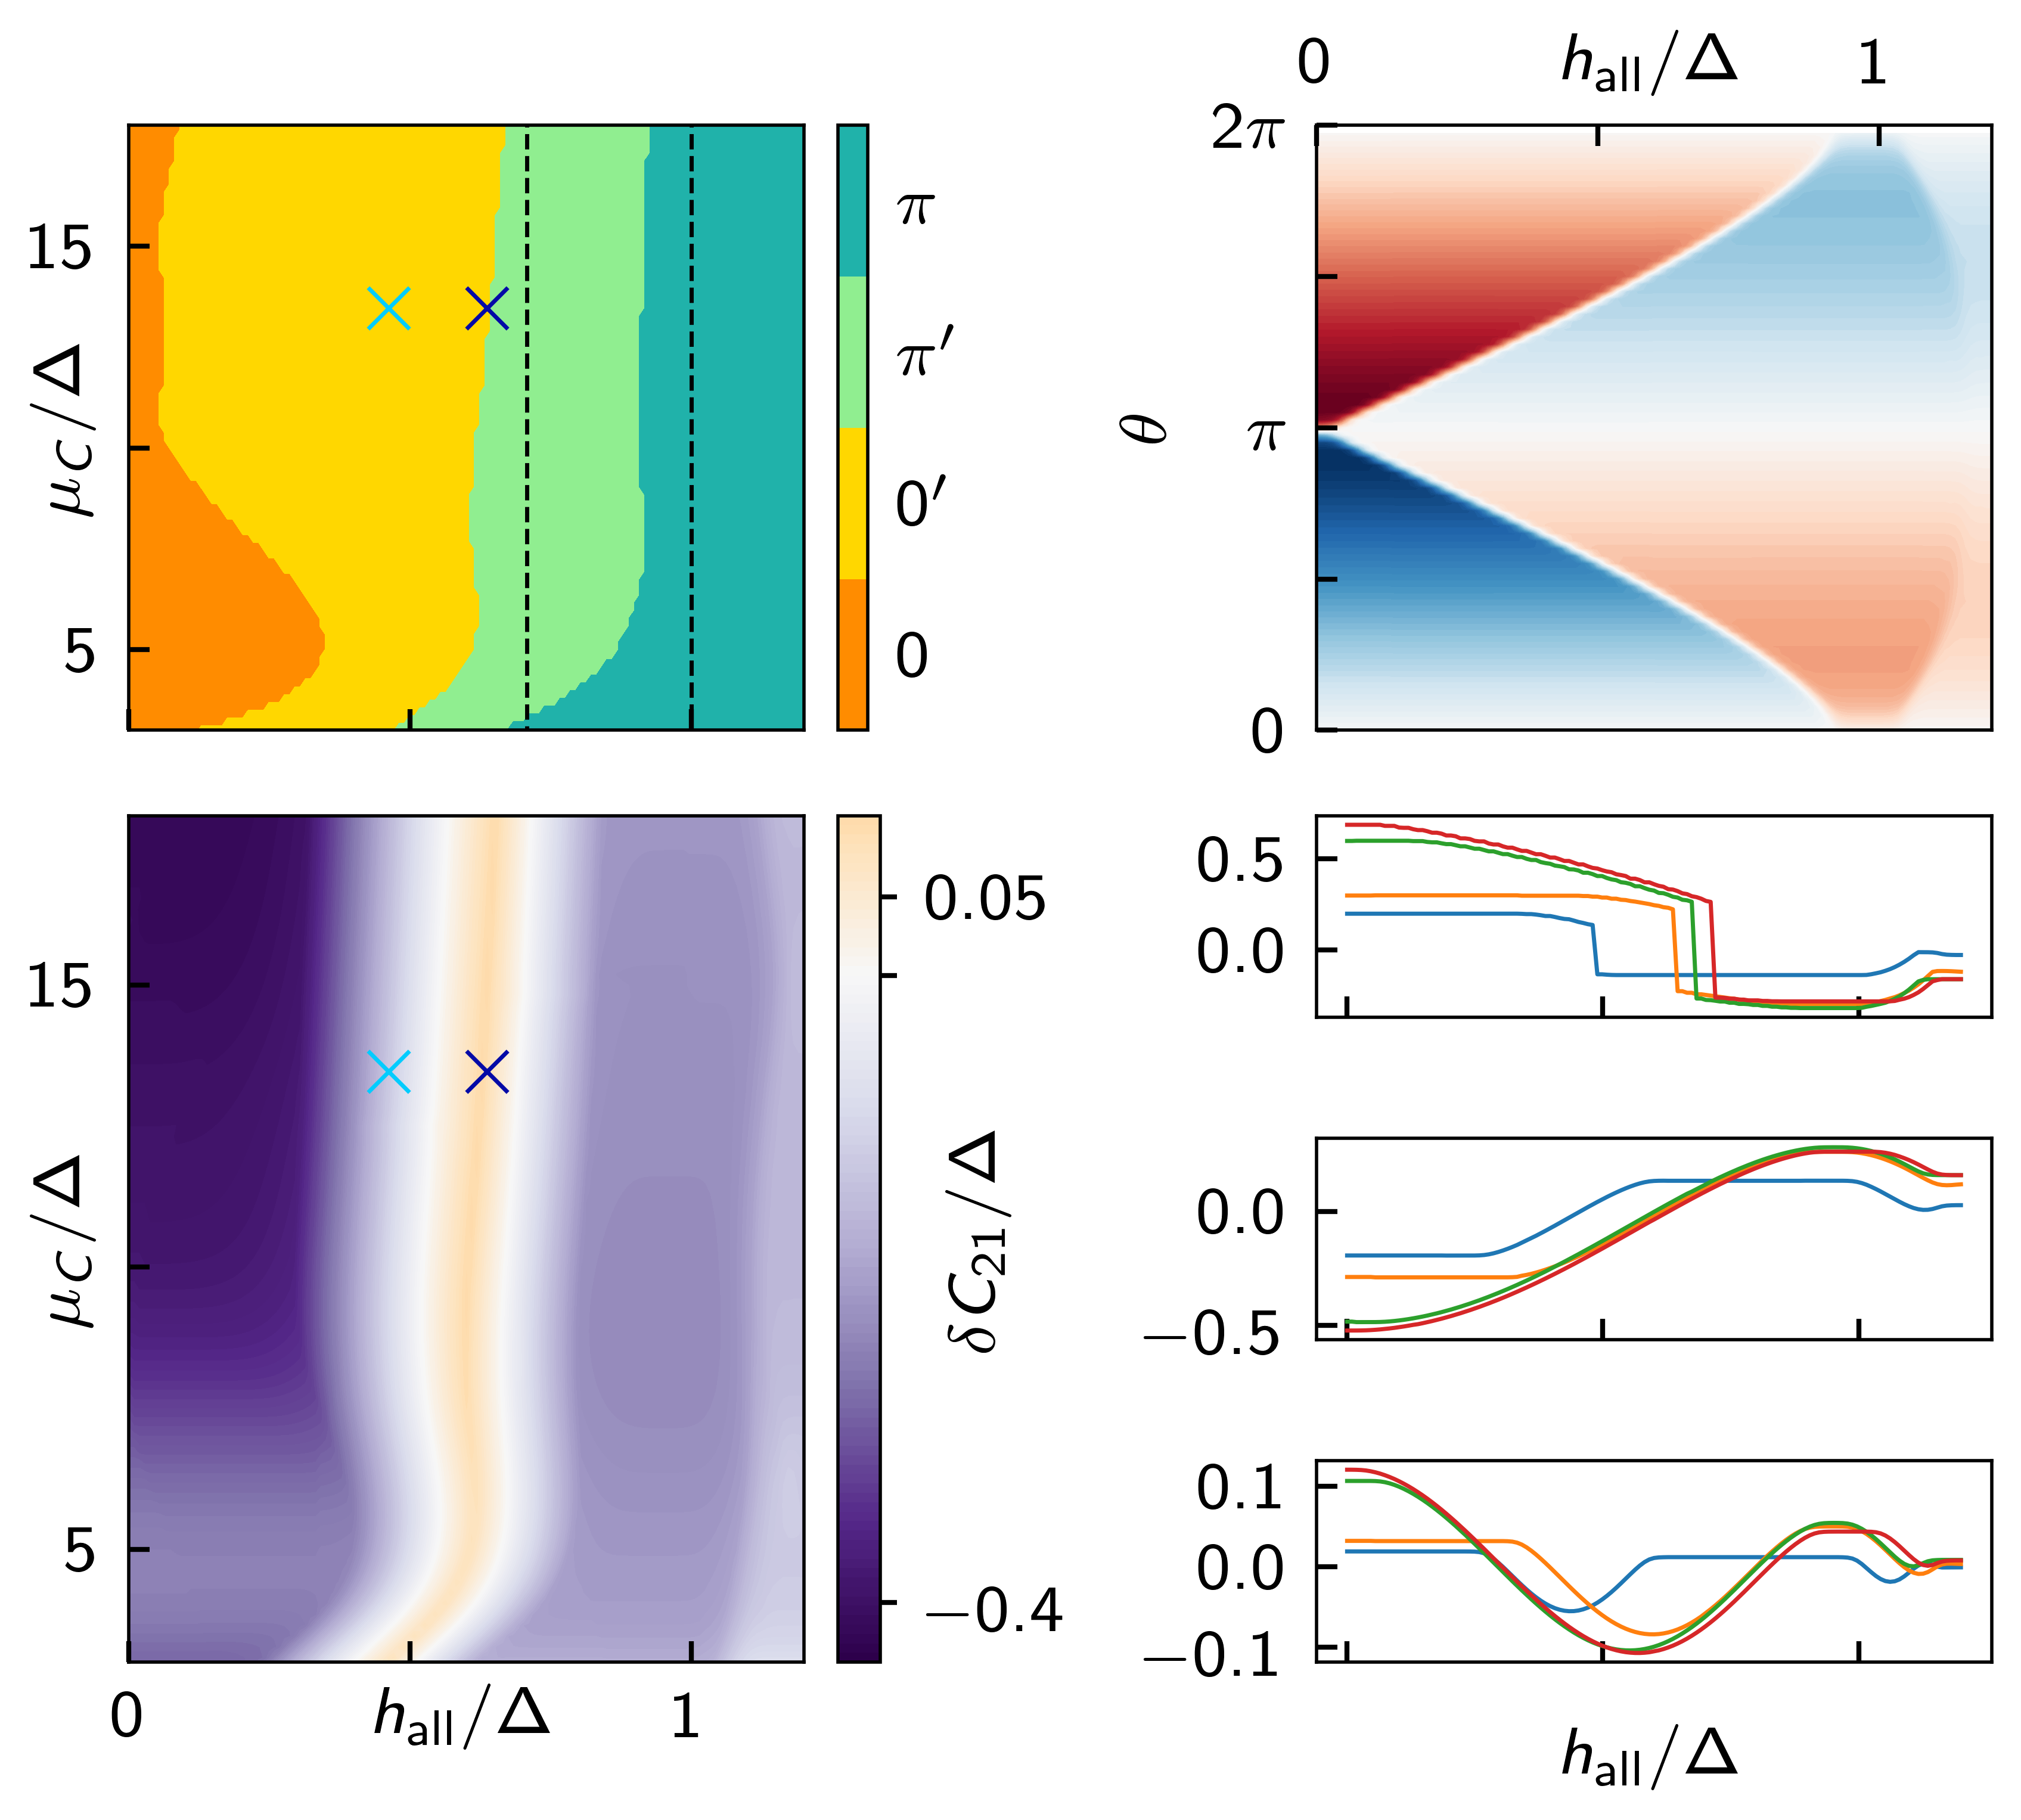

In [18]:
b_cut_idx = 70

coords_1 = [50, 70]
coords_2 = [69, 70]

fig = plt.figure(dpi=1000, figsize=(3.375, 3.375 * 0.9), layout="constrained")
spec = fig.add_gridspec(4, 2, height_ratios=[3, 1, 1, 1])

ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[1:4, 0])
ax4 = fig.add_subplot(spec[1, 1])
ax5 = fig.add_subplot(spec[2, 1])
ax6 = fig.add_subplot(spec[3, 1])

ax1.set_rasterization_zorder(0)
ax3.set_rasterization_zorder(0)

##############################################################

levels = np.linspace(0, 3.2, 5)

im1 = ax1.contourf(
    a / a_scale, b / b_scale, pd, levels=levels, cmap=pd_cmap, zorder=-30
)

ax1.scatter(
    a_ax[coords_1[0]] / a_scale,
    b_ax[coords_1[1]] / b_scale,
    color=line_colors[0],
    marker="x",
)
ax1.scatter(
    a_ax[coords_2[0]] / a_scale,
    b_ax[coords_2[1]] / b_scale,
    color=line_colors[1],
    marker="x",
)

ax1.set_xticks([0, 0.5, 1])
ax1.set_xticklabels([])
# ax1.set_xlabel(a_label)

ax1.set_ylim(3, 18)
ax1.set_yticks([5, 10, 15])
ax1.set_yticklabels([r"$5$", r"", r"$15$"])
ax1.set_ylabel(b_label, labelpad=-8)

ax1.vlines(
    [1 / np.sqrt(2), 1],
    b_ax.min() / b_scale,
    b_ax.max() / b_scale,
    color="k",
    linestyles="--",
    linewidths=0.5,
)

#############################################################
ax2.contourf(
    a_ax / a_scale,
    theta_ax / np.pi,
    I[:, b_cut_idx, :].T,
    levels=100,
    norm=mpl.colors.CenteredNorm(0),
    cmap="RdBu",
    zorder=-30,
)
# ax2.plot(a_ax / a_scale, I_c[:, b_cut_idx] / I_0, "-k")
# ax2.fill_between(
#     x=a_ax / a_scale,
#     y1=I_c[:, b_cut_idx] / I_0 * (I_c[:, b_cut_idx] < 0),
#     y2=0,
#     color="C0",
#     alpha=0.2,
#     linewidth=0,
# )
# ax2.fill_between(
#     x=a_ax / a_scale,
#     y1=I_c[:, b_cut_idx] / I_0 * (I_c[:, b_cut_idx] > 0),
#     y2=0,
#     color="C3",
#     alpha=0.2,
#     linewidth=0,
# )

ax2.set_xlim(0, 1.2)
ax2.set_xticks([0, 0.5, 1], labels=[r"$0$", r"", r"$1$"])
ax2.xaxis.tick_top()
ax2.set_xlabel(a_label, labelpad=-5)
ax2.xaxis.set_label_position("top")

ax2.set_yticks([0, 0.5, 1, 1.5, 2], labels=[r"$0$", r"", r"$\pi$", r"", r"$2\pi$"])
#ax2.yaxis.tick_right()
ax2.set_ylabel(r"$\theta$")
#ax2.yaxis.set_label_position("right")


# ax2.set_ylim(-0.82, 0.82)
# ax2.set_yticks([-0.8, -0.4, 0, 0.4, 0.8], labels=[r"$-0.8$", r"", r"", r"", r"$0.8$"])
# ax2.yaxis.tick_right()
# ax2.set_ylabel(r"$I_\mathrm{c}/I_0$", labelpad=-15)
# ax2.yaxis.set_label_position("right")

################################################################
im3 = ax3.contourf(
    a / a_scale,
    b / b_scale,
    (diffabs) / Delta_0,
    levels=100,
    norm=mpl.colors.CenteredNorm(0),
    cmap="PuOr_r",
    zorder=-30,
)

ax3.set_xticks([0, 0.5, 1], labels=[r"$0$", r"", r"$1$"])
ax3.set_xlabel(a_label, labelpad=-8)

ax3.set_ylim(3, 18)
ax3.set_yticks([5, 10, 15], labels=[r"$5$", r"", r"$15$"])
ax3.set_ylabel(b_label, labelpad=-8)

ax3.scatter(
    a_ax[coords_1[0]] / a_scale,
    b_ax[coords_1[1]] / b_scale,
    color=line_colors[0],
    marker="x",
)
ax3.scatter(
    a_ax[coords_2[0]] / a_scale,
    b_ax[coords_2[1]] / b_scale,
    color=line_colors[1],
    marker="x",
)

###########################################
# ax4.fill_between(
#     x=    a_ax / a_scale,
#     #y1=I[coords_1[0], coords_1[1]] / I_0,
#     y1=I_c[:, coords_1[1]] / I_0,
#     y2=0,
#     color=line_colors[0],
#     alpha=0.2,
#     linewidth=0,
# )

ax4.plot(
    a_ax / a_scale,
    I_c[:, [10, 30, 50, 70]] / I_0,
    "-",
 )

ax5.plot(
    a_ax / a_scale,
    cF_k[:, [10, 30, 50, 70], 1] / Delta_0,
    "-",
)

ax6.plot(
    a_ax / a_scale,
    cF_k[:, [10, 30, 50, 70], 2] / Delta_0,
    "-",
)

ax4.set_xlabel("")
ax5.set_xlabel("")
ax6.set_xlabel(a_label)

ax4.set_xticks([0, 0.5, 1], labels=[])
ax5.set_xticks([0, 0.5, 1], labels=[])
ax6.set_xticks([0, 0.5, 1], labels=[])

# ax4.set_xlim(0, 2 * np.pi)
# ax4.set_xticks(np.array([0, 0.5, 1, 1.5, 2]) * np.pi, labels=[])

# ax4.set_ylim(-0.48, 0.48)
# ax4.set_yticks(np.array([-0.4, 0, 0.4]), labels=[r"$-0.4$", r"", r"$0.4$"])
# ax4.set_ylabel(r"$I/I_0$", labelpad=-15)
# ax4.yaxis.set_label_position("right")
# ax4.yaxis.tick_right()

# ax5.fill_between(
#     x=theta_ax,
#     y1=I[coords_2[0], coords_2[1]] / I_0,
#     y2=0,
#     color=line_colors[1],
#     alpha=0.2,
#     linewidth=0,
# )

# ax5.plot(
#     theta_ax,
#     I[coords_2[0], coords_2[1]] / I_0,
#     "-",
#     color=line_colors[1],
# )

# ax5.set_xticks(
#     np.array([0, 0.5, 1, 1.5, 2]) * np.pi, labels=[r"$0$", r"", r"", r"", r"$2\pi$"]
# )
# ax5.set_xlabel(r"$\phi$", labelpad=-5)
# ax5.set_xlim(0, 2 * np.pi)

# ax5.yaxis.set_label_position("right")
# ax5.yaxis.tick_right()
# ax5.set_ylim(-0.45, 0.45)
# ax5.set_ylabel(r"$I/I_0$", labelpad=-15)
# ax5.set_yticks(np.array([-0.4, 0, 0.4]), labels=[r"$-0.4$", r"", r"$0.4$"])

# spec.tight_layout(fig)

#########################################
cbar1 = fig.colorbar(im1, ax=ax1)
cbar1.set_ticks([1 / 8 * 3.2, 3 / 8 * 3.2, 5 / 8 * 3.2, 7 / 8 * 3.2])
cbar1.set_ticklabels([r"$0$", r"$0'$", r"$\pi'$", r"$\pi$"])
cbar1.ax.tick_params(length=0)

#########################################
cbar3 = fig.colorbar(im3, ax=ax3, format="%3.2f")
cbar3.set_ticks([-0.4, 0, 0.05], labels=[r"$-0.4$", "", r"$0.05$"])
cbar3.ax.tick_params(length=2, direction="out")
cbar3.set_label(r"$\delta C_{21} / \Delta$", labelpad=-15)

#########################################
# axins = ax2.inset_axes([0.01, 0.01, 0.5, 0.5])
# axins.set_rasterization_zorder(0)

# im = axins.contourf(
#     a / a_scale,
#     b / b_scale,
#     I_c / I_0,
#     levels=100,
#     norm=mpl.colors.CenteredNorm(),
#     cmap="RdBu_r",
#     zorder=-30,
# )

# axins.hlines([b_ax[b_cut_idx] / b_scale], 0, 1.2, colors="k", linestyles="--")

# axins.set_xticks([0, 0.5, 1])
# axins.set_xticklabels([])

# axins.set_ylim(3, 18)
# axins.set_yticks([5, 10, 15], labels=[])

###################################
# cb_axins = ax2.inset_axes([0.01, 0.52, 0.5, 0.02])
# cbar2 = fig.colorbar(im, cax=cb_axins, orientation="horizontal")
# cbar2.set_ticks([-0.3, 0, 0.7], labels=[r"$-0.3$", "", r"$0.7$"])
# cbar2.ax.xaxis.set_label_position("top")
# cbar2.ax.xaxis.tick_top()
# cbar2.ax.tick_params(length=2, direction="out")
# cbar2.set_label(r"$I_\mathrm{c} / I_0$", labelpad=-5)

# cb_axins = ax2.inset_axes([-0.03, 0.01, 0.02, 0.5])
# cbar2 = fig.colorbar(im, cax=cb_axins)

# cbar2.set_ticks([-0.3, 0, 0.7], labels=[r"$-0.3$", "", r"$0.7$"])
# cbar2.ax.yaxis.set_label_position("left")
# cbar2.ax.yaxis.tick_left()
# cbar2.ax.tick_params(length=2, direction="out")
# cbar2.set_label(r"$I_\mathrm{c} / I_0$", labelpad=-15)

/scratch/37980111/ipykernel_3251/1103990844.py:245: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(f"Fig3-open.svg")
/scratch/37980111/ipykernel_3251/1103990844.py:246: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(f"Fig3-open.pdf")


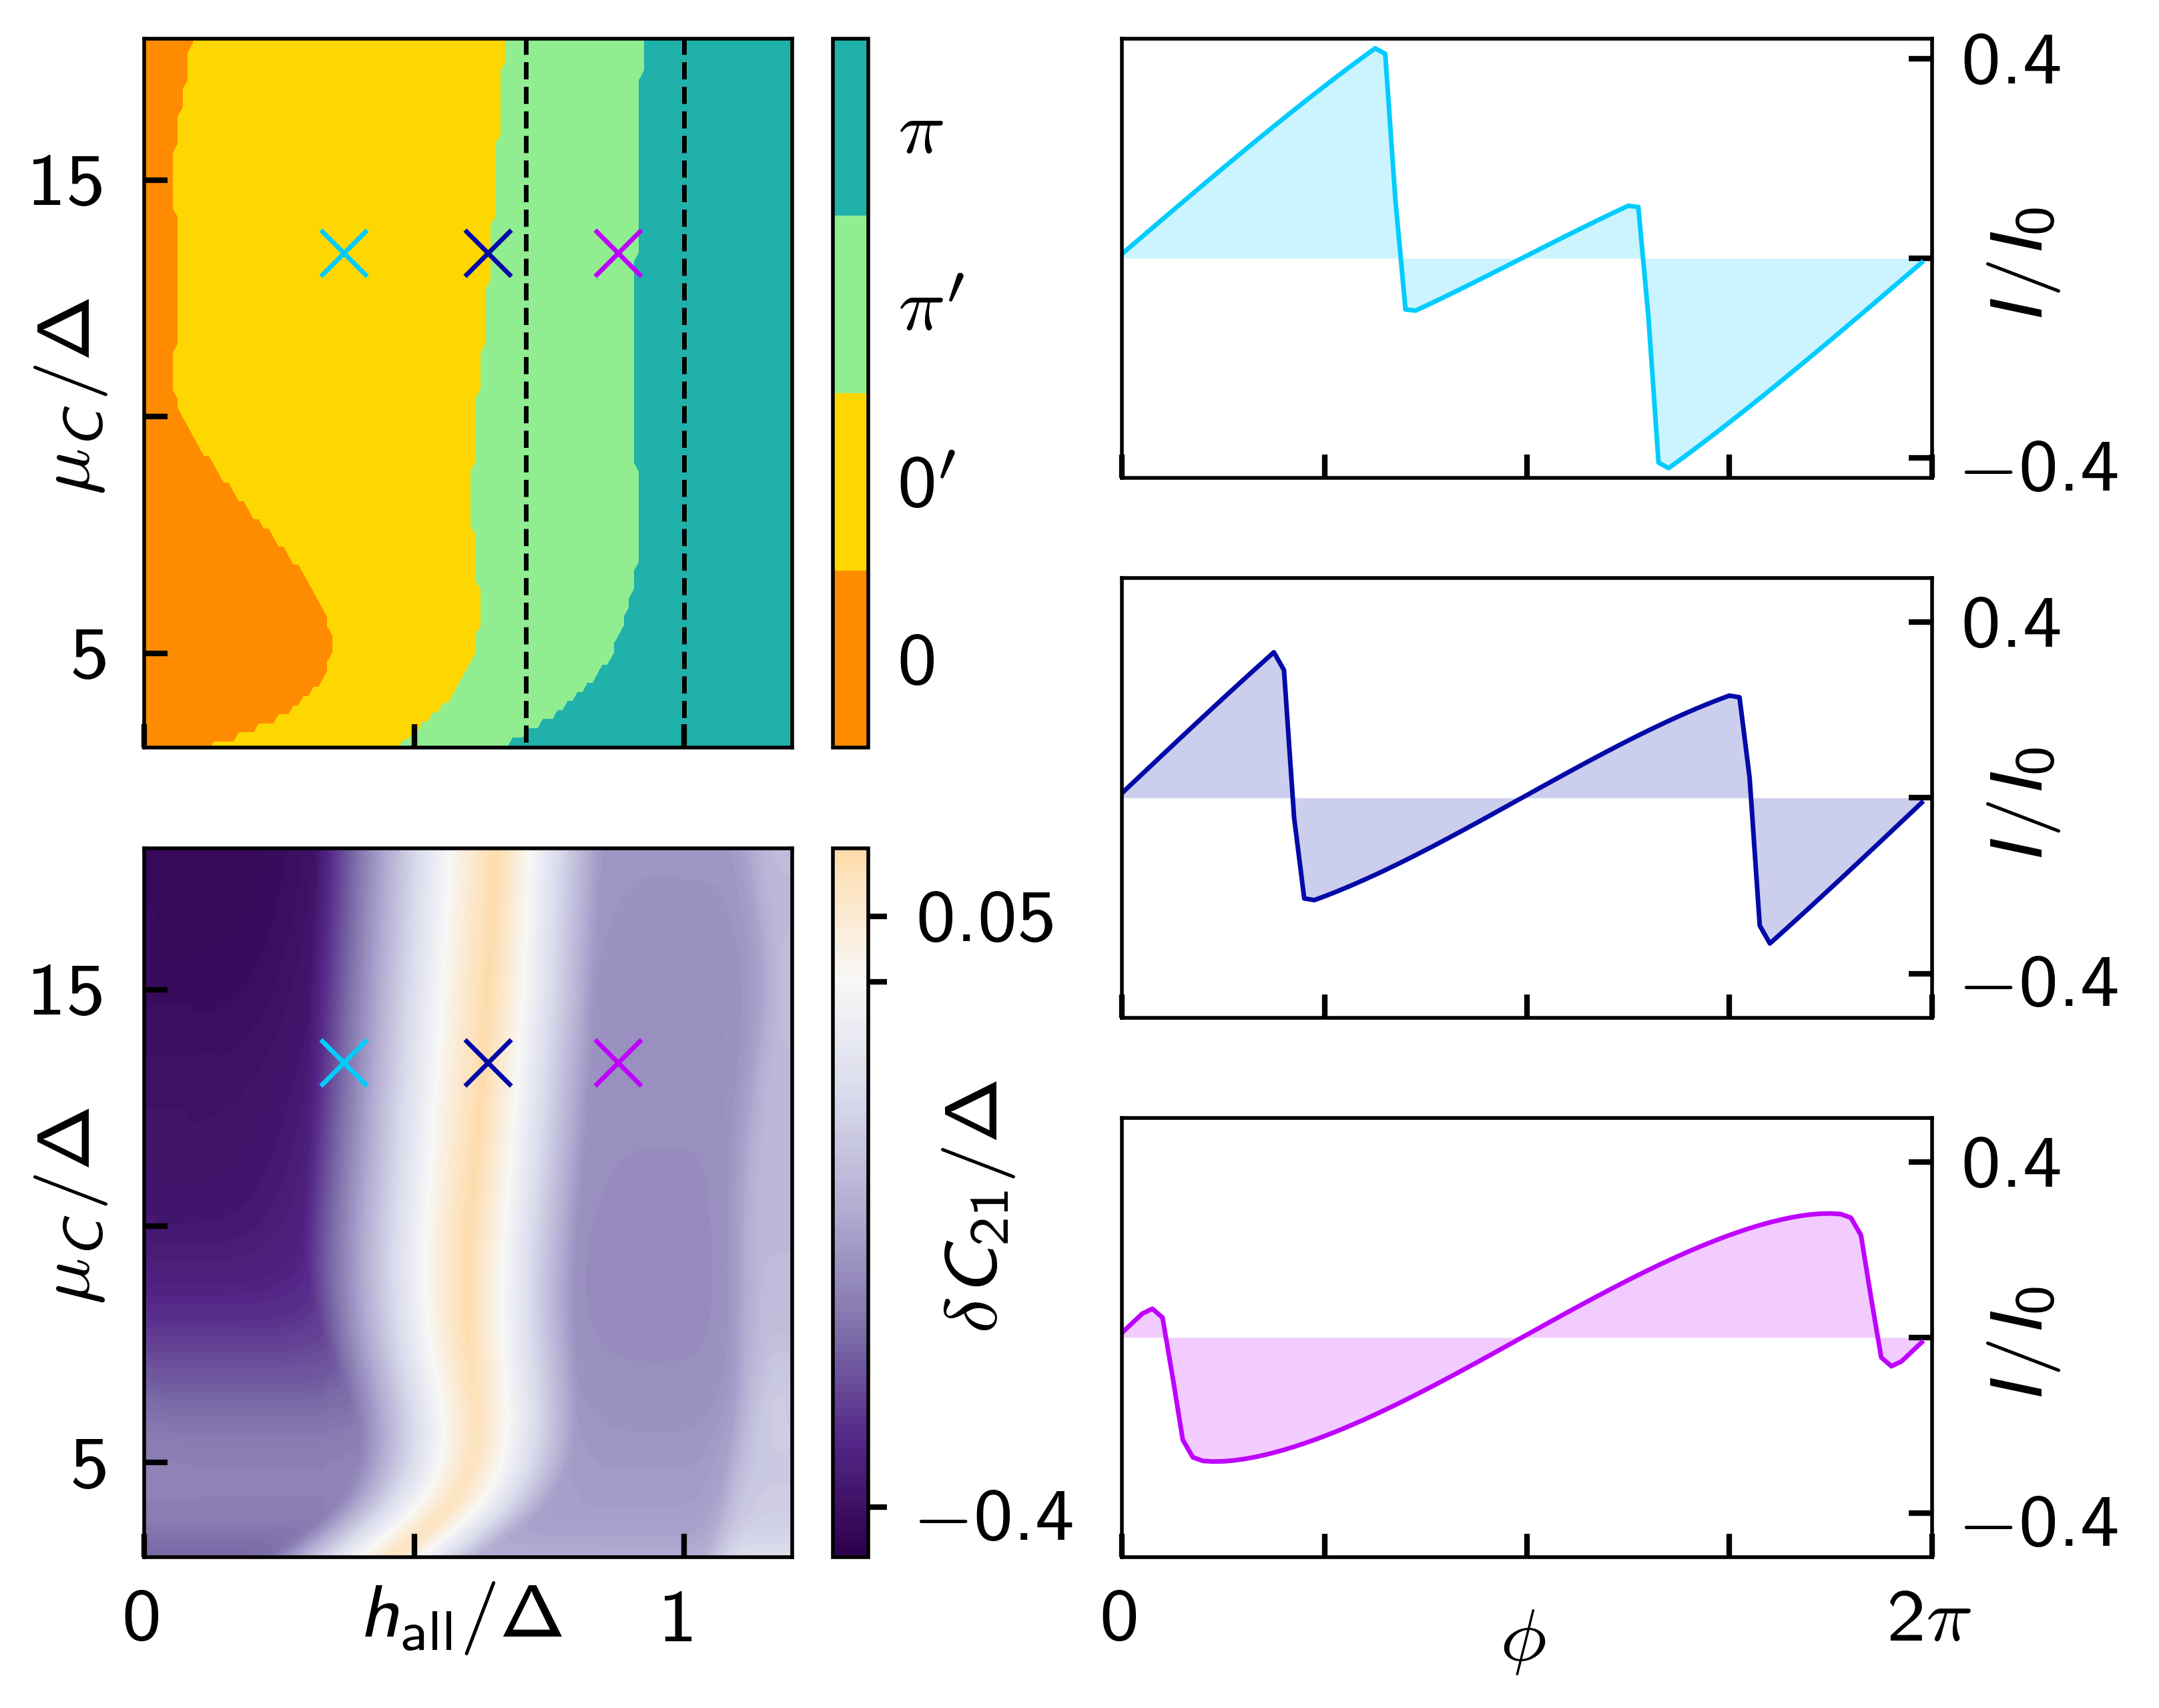

In [21]:
b_cut_idx = 70

coords_1 = [40, 70]
coords_2 = [69, 70]
coords_3 = [95, 70]

fig = plt.figure(dpi=1000, figsize=(3.375, 3.375 * 0.8), layout="constrained")
spec = fig.add_gridspec(6, 2, height_ratios=[1, 1, 1, 1, 1, 1])

ax11 = fig.add_subplot(spec[0:3, 0])
ax21 = fig.add_subplot(spec[3:6, 0])

ax12 = fig.add_subplot(spec[0:2, 1])
ax22 = fig.add_subplot(spec[2:4, 1])
ax32 = fig.add_subplot(spec[4:6, 1])

ax11.set_rasterization_zorder(0)
ax21.set_rasterization_zorder(0)

##############################################################

levels = np.linspace(0, 3.2, 5)

im1 = ax11.contourf(
    a / a_scale, b / b_scale, pd, levels=levels, cmap=pd_cmap, zorder=-30
)

ax11.scatter(
    a_ax[coords_1[0]] / a_scale,
    b_ax[coords_1[1]] / b_scale,
    color=line_colors[0],
    marker="x",
)
ax11.scatter(
    a_ax[coords_2[0]] / a_scale,
    b_ax[coords_2[1]] / b_scale,
    color=line_colors[1],
    marker="x",
)
ax11.scatter(
    a_ax[coords_3[0]] / a_scale,
    b_ax[coords_3[1]] / b_scale,
    color=line_colors[2],
    marker="x",
)


ax11.set_xticks([0, 0.5, 1], labels=[])#, labels=[r"$0$", r"", r"$1$"])
#ax11.set_xlabel(a_label, labelpad=-8)

ax11.set_ylim(3, 18)
ax11.set_yticks([5, 10, 15])
ax11.set_yticklabels([r"$5$", r"", r"$15$"])
ax11.set_ylabel(b_label, labelpad=-8)

ax11.vlines(
    [1 / np.sqrt(2), 1],
    b_ax.min() / b_scale,
    b_ax.max() / b_scale,
    color="k",
    linestyles="--",
    linewidths=0.5,
)

################################################################
im2 = ax21.contourf(
    a / a_scale,
    b / b_scale,
    (diffabs) / Delta_0,
    levels=100,
    norm=mpl.colors.CenteredNorm(0),
    cmap="PuOr_r",
    zorder=-30,
)

ax21.set_xticks([0, 0.5, 1], labels=[r"$0$", r"", r"$1$"])
ax21.set_xlabel(a_label, labelpad=-8)

ax21.set_ylim(3, 18)
ax21.set_yticks([5, 10, 15], labels=[r"$5$", r"", r"$15$"])
ax21.set_ylabel(b_label, labelpad=-8)

ax21.scatter(
    a_ax[coords_1[0]] / a_scale,
    b_ax[coords_1[1]] / b_scale,
    color=line_colors[0],
    marker="x",
)
ax21.scatter(
    a_ax[coords_2[0]] / a_scale,
    b_ax[coords_2[1]] / b_scale,
    color=line_colors[1],
    marker="x",
)
ax21.scatter(
    a_ax[coords_3[0]] / a_scale,
    b_ax[coords_3[1]] / b_scale,
    color=line_colors[2],
    marker="x",
)

###########################################

ax12.fill_between(
    x=theta_ax,
    y1=I[coords_1[0], coords_1[1]] / I_0,
    y2=0,
    color=line_colors[0],
    alpha=0.2,
    linewidth=0,
)

ax12.plot(
    theta_ax,
    I[coords_1[0], coords_1[1]] / I_0,
    "-",
    color=line_colors[0],
)

ax12.set_xlim(0, 2 * np.pi)
ax12.set_xticks(np.array([0, 0.5, 1, 1.5, 2]) * np.pi, labels=[])

ax12.set_ylim(-0.55, 0.55)
ax12.set_yticks(np.array([-0.5, 0, 0.5]), labels=[r"$-0.4$", r"", r"$0.4$"])
ax12.set_ylabel(r"$I/I_0$", labelpad=-15)
ax12.yaxis.set_label_position("right")
ax12.yaxis.tick_right()

##########################################

ax22.fill_between(
    x=theta_ax,
    y1=I[coords_2[0], coords_2[1]] / I_0,
    y2=0,
    color=line_colors[1],
    alpha=0.2,
    linewidth=0,
)

ax22.plot(
    theta_ax,
    I[coords_2[0], coords_2[1]] / I_0,
    "-",
    color=line_colors[1],
)

ax22.set_xticks(
    np.array([0, 0.5, 1, 1.5, 2]) * np.pi, labels=[r"", r"", r"", r"", r""]
)
ax22.set_xlim(0, 2 * np.pi)

ax22.set_ylim(-0.5, 0.5)
ax22.set_yticks(np.array([-0.4, 0, 0.4]), labels=[r"$-0.4$", r"", r"$0.4$"])
ax22.set_ylabel(r"$I/I_0$", labelpad=-15)
ax22.yaxis.set_label_position("right")
ax22.yaxis.tick_right()

##########################################

ax32.fill_between(
    x=theta_ax,
    y1=I[coords_3[0], coords_3[1]] / I_0,
    y2=0,
    color=line_colors[2],
    alpha=0.2,
    linewidth=0,
)

ax32.plot(
    theta_ax,
    I[coords_3[0], coords_3[1]] / I_0,
    "-",
    color=line_colors[2],
)

ax32.set_xticks(
    np.array([0, 0.5, 1, 1.5, 2]) * np.pi, labels=[r"$0$", r"", r"", r"", r"$2\pi$"]
)
ax32.set_xlabel(r"$\phi$", labelpad=-5)
ax32.set_xlim(0, 2 * np.pi)

ax32.set_ylim(-0.5, 0.5)
ax32.set_yticks(np.array([-0.4, 0, 0.4]), labels=[r"$-0.4$", r"", r"$0.4$"])
ax32.set_ylabel(r"$I/I_0$", labelpad=-15)
ax32.yaxis.set_label_position("right")
ax32.yaxis.tick_right()


#########################################

spec.tight_layout(fig, w_pad=2)

#########################################
cbar1 = fig.colorbar(im1, ax=ax11)#, location='top')
cbar1.set_ticks([1 / 8 * 3.2, 3 / 8 * 3.2, 5 / 8 * 3.2, 7 / 8 * 3.2])
cbar1.set_ticklabels([r"$0$", r"$0'$", r"$\pi'$", r"$\pi$"])
cbar1.ax.tick_params(length=0)

#########################################
cbar2 = fig.colorbar(im2, ax=ax21, format="%3.2f")# location='top')
cbar2.set_ticks([-0.4, 0, 0.05], labels=[r"$-0.4$", "", r"$0.05$"])
cbar2.ax.tick_params(length=2, direction="out")
cbar2.set_label(r"$\delta C_{21} / \Delta$", labelpad=-15)

# #########################################
# axins = ax2.inset_axes([0.01, 0.01, 0.5, 0.5])
# axins.set_rasterization_zorder(0)

# im = axins.contourf(
#     a / a_scale,
#     b / b_scale,
#     I_c / I_0,
#     levels=100,
#     norm=mpl.colors.CenteredNorm(),
#     cmap="RdBu_r",
#     zorder=-30,
# )

# axins.hlines([b_ax[b_cut_idx] / b_scale], 0, 1.2, colors="k", linestyles="--")

# axins.set_xticks([0, 0.5, 1])
# axins.set_xticklabels([])

# axins.set_ylim(3, 18)
# axins.set_yticks([5, 10, 15], labels=[])

# ###################################
# # cb_axins = ax2.inset_axes([0.01, 0.52, 0.5, 0.02])
# # cbar2 = fig.colorbar(im, cax=cb_axins, orientation="horizontal")
# # cbar2.set_ticks([-0.3, 0, 0.7], labels=[r"$-0.3$", "", r"$0.7$"])
# # cbar2.ax.xaxis.set_label_position("top")
# # cbar2.ax.xaxis.tick_top()
# # cbar2.ax.tick_params(length=2, direction="out")
# # cbar2.set_label(r"$I_\mathrm{c} / I_0$", labelpad=-5)

# cb_axins = ax2.inset_axes([-0.03, 0.01, 0.02, 0.5])
# cbar2 = fig.colorbar(im, cax=cb_axins)

# cbar2.set_ticks([-0.3, 0, 0.7], labels=[r"$-0.3$", "", r"$0.7$"])
# cbar2.ax.yaxis.set_label_position("left")
# cbar2.ax.yaxis.tick_left()
# cbar2.ax.tick_params(length=2, direction="out")
# cbar2.set_label(r"$I_\mathrm{c} / I_0$", labelpad=-15)

fig.savefig(f"Fig4-open.svg")